Sommaire

1  Introductioo
2  Importations
3  Fonctions
4  Decouverte des données
4.1  Train
4.1.1  Etude de la TARGET
4.2  Test
4.3  Nettoyage
4.4  Outliers
4.5  Corrélations
5  Feature engineering
6  Modélisation
6.1  Séparation des dataframes
6.2  Baseline
6.3  Rééquilibrage et choix du modèle
6.3.1  Class Weight
6.3.2  Smote
6.3.3  UnderSampling
6.3.4  Predictions
6.3.4.1  Ajout des nouvelles variables sur le test
7  Interprétation des résultats avec SHAP
7.1  Interprétation globale
7.2  Interprétation Locale
Partie 6 : Analyse du Data Drift avec Evidently AI

PROJET_7: Implémentez un modèle de scoring
Objectif : vous etes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la 
consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. L’entreprise souhaite mettre en œuvre un outil 
de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé 
ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées.
Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois 
expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de
disposer de leurs informations personnelles et de les explorer facilement.
Mission :
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.
Source de données : https://www.kaggle.com/competitions/home-credit-default-risk/data

In [1]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import gc
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import space_eval, STATUS_OK

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

%pip install lightgbm
%pip install lime

import lightgbm as lgb
import lime

from lime import lime_tabular

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%pip install missingno

import missingno as msno
import numpy as np
import pandas as pd
import pickle 
import random
import re
import seaborn as sns
#import shap

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import time

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import shap

c:\Users\Dell\anaconda3\envs\tf_n\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print('Version des librairies utilisées :')


print('Matplotlib            : ' + mpl.__version__)
print('Missingno             : ' + msno.__version__)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
#print('Shap                  : ' + shap.__version__)
print('Sklearn               : ' + sklearn.__version__ )

Version des librairies utilisées :
Matplotlib            : 3.9.4
Missingno             : 0.5.2
NumPy                 : 1.26.4
Pandas                : 2.2.3
Seaborn               : 0.13.2
Sklearn               : 1.6.1


In [7]:
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

#warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

LES FONCTIONS

In [8]:
def timeit(f):
    ''' 
    fonction décoratrice qui donne le temps d'éxecution d'une autre fonction
    '''
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

Fonction qui traite les valeurs manquantes:

In [9]:
@timeit
def missing_values(df):
        '''
        Fonction qui calcule les valeurs manquantes d'un dataset
        
        '''
        # Nombre total de valeurs manquantes
        mis_val = df.isna().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent =(df.isnull().sum() / len(df))*100
        
        # Construction d'un tableau avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renommage des colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% total des valeurs'})
        
        # On range de manière décroissante 
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% total des valeurs', ascending=False).round(1)
        
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [10]:
@timeit
def description_dataset(data, name):
    print("ON TRAITE LES DONNEES ", name)
    msno.bar(data)
    
    display(data.head(3))
    print(f'Taille :-------------------------------------------------------------- {data.shape}')
    
    print("## --0- ##"*10)
    print("VALEURS DIFFERENTES PAR VARIABLES (%): ")
    table = missing_values(data)
    display(table.head(50))

    print("## --0- ##"*10)
    print("VALEURS DIFFERENTES PAR VARIABLES : ")
    for col in data:
        if data[col].nunique() < 30:
            print (f'{col :-<70} {data[col].unique()}')
        else : 
            print(f'{col :-<70} CONTIENT {data[col].nunique()} VALEURS DIFFERENTES')
    print("## --0- ##"*10)
    print(f"NB DE DOUBLONS : {data.duplicated().sum()}")

In [11]:
# Encodage en one hot des variables catégorielles
def cleaning_categories(col):
    '''
    Fonction qui nettoie une phrase de ses caractères spéciaux.
    Et la passe en majuscule( pour un passage en nom de colonne avec one hot)
    '''
    col = str(col).replace('-', '').replace('+', '').replace('/', ' ').replace(':', '_')
    col = str(col).upper()
    return col

In [12]:
@timeit
def cat_encoder(features, test_features):
    '''
    Fonction qui fais un one hot encodage sur les variables
    catégorielles à l'aide de get_dummies.
    Elle fais un label encoder sur les variables binaires. 
    Elle traite les valeurs manquantes comme des catégories.
    Elle retourne les datasets encodés.
    '''
    label_encoder = LabelEncoder()
    
    categorical_columns_train  = []
    categorical_columns_test  = []
    
    for col in features :
        if col != "TARGET":
            if features[col].dtype == object:
                #Label encodage pour les variables binaires
                if features[col].nunique()==2:
                    features[col] = label_encoder.fit_transform(features[col])
                #récupération des colonnes où on fera un one hot encodage
                elif features[col].nunique()>2:
                    categorical_columns_train.append(col)
                    
    features = pd.get_dummies(features, columns = categorical_columns_train,dummy_na= True)
    
    for col in test_features :
        if test_features[col].dtype == object:
            #Label encodage pour les variables binaires
            if test_features[col].nunique()==2:
                test_features[col] = label_encoder.fit_transform(test_features[col])
            #récupération des colonnes où on fera un one hot encodage
            elif test_features[col].nunique()>2:
                categorical_columns_test.append(col)
    
    test_features = pd.get_dummies(test_features,columns = categorical_columns_test, dummy_na= True)
    
    #Alignement des dataframes
    features, test_features = features.align(test_features, join= 'inner', axis=1)

    return features, test_features

In [13]:
### FONCTION POUR NETTOYER ET ENCODER LES DATAS

@timeit
def clean_data(train, test):

    # Valeurs abérantes
    train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
    test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

    #Création de feature
    df_train = train.copy()
    df_test = test.copy()

    #train data
    df_train['PROPORTION_LIFE_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']
    df_train['INCOME_TO_CREDIT_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
    df_train['INCOME_TO_ANNUITY_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_ANNUITY']
    df_train['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = df_train['INCOME_TO_ANNUITY_RATIO'] * df_train['DAYS_BIRTH']
    df_train['CREDIT_TO_ANNUITY_RATIO'] = df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']
    df_train['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = df_train['CREDIT_TO_ANNUITY_RATIO'] * df_train['DAYS_BIRTH']
    df_train['INCOME_TO_FAMILYSIZE_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['CNT_FAM_MEMBERS']
    df_train['ANNUITY_INCOME_PERC'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']

    #Test data
    df_test['PROPORTION_LIFE_EMPLOYED'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
    df_test['INCOME_TO_CREDIT_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']
    df_test['INCOME_TO_ANNUITY_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_ANNUITY']
    df_test['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = df_test['INCOME_TO_ANNUITY_RATIO'] * df_test['DAYS_BIRTH']
    df_test['CREDIT_TO_ANNUITY_RATIO'] = df_test['AMT_CREDIT'] / df_train['AMT_ANNUITY']
    df_test['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = df_test['CREDIT_TO_ANNUITY_RATIO'] * df_test['DAYS_BIRTH']
    df_test['INCOME_TO_FAMILYSIZE_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']
    df_test['ANNUITY_INCOME_PERC'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']

    features=df_train.copy()
    test_features=df_test.copy()

    # Extraction des ID
    
    train_ids = features["SK_ID_CURR"]
    test_ids = test_features["SK_ID_CURR"]

    
    # Extraction des Targets
    labels = features['TARGET']
    
    #labels.reset_index(drop=True, inplace=True)
   
    # Suppression des ID and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    features, test_features = cat_encoder(features, test_features)
    
    
    # Extraction des noms des Feature
    feat_name = list(features.columns)

    #Imputation des Nan 
    imputer = SimpleImputer(strategy = 'median')

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale les features
    scaler = MinMaxScaler(feature_range = (0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Création des dataset
    features_set=pd.DataFrame(features,columns=feat_name)
    test_features_set=pd.DataFrame(test_features,columns=feat_name)
    
    #Ajout de la colonne TARGET et des ids
    features_set['TARGET']=labels
    features_set["SK_ID_CURR"] = train_ids
    test_features_set['SK_ID_CURR'] = test_ids
    
    #Passage des id en index
    features_set.set_index('SK_ID_CURR', inplace = True)
    test_features_set.set_index('SK_ID_CURR',inplace = True)

    print('Training Data Shape: ', features_set.shape)
    print('Testing Data Shape: ', test_features_set.shape)
    
    return features_set, test_features_set

In [14]:
@timeit
def echantillonage(df_X, df_y):
    X = df_X.copy()
    y = df_y.copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_valid, y_train, y_valid

In [15]:
@timeit
def plot_roc_curve(classifiers, X, y, n_splits=5):

    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            clf.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = clf.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, thresholds = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            thresholds = auc(fpr, tpr)

            aucs.append(thresholds)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
def cout_metier(y_true, y_pred, seuil=0.5, fn_value=-0.7, fp_value=-0.2, vp_value=0, vn_value=0.2):

    '''
    Métrique métier tentant de minimiser le risque d'accord prêt pour la
    banque en pénalisant les faux négatifs.
    '''
    
    # Liste des prédiction selon un seuil de probabilité
    y_seuil=[]

    for i in y_pred:
        if i >= seuil:
            y_seuil.append(1)
        elif i < seuil:
            y_seuil.append(0)
    
    #Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    vn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    vp = mat_conf[1, 1]
    
    # Gain total
    J = vp*vp_value + vn*vn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + vn)*vn_value + (fn + vp)*vp_value
    
    # Gain minimum
    min_J = (fp + vn)*fp_value + (fn + vp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [17]:
skf = StratifiedKFold(n_splits=2)
@timeit
def model_v1(predictor, features, labels, eval_metric, cv=skf, smote = True):
    
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = labels
    
    # Remove the ids and target
    features = features
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    #features = pipeline.fit_transform(features)
    targets = np.array(targets) 
    
    # Ensure all data is stored as floats
    #features = features.astype(np.float64)

    if smote == True:
        # Increase the data to get a bigger proportion of positif targets
        sm = SMOTE(random_state=seed, sampling_strategy=0.2)
        # the ratio is chosen to correspond to the pareto law with the 80%/20% ratio
        features_res, targets_res = sm.fit_resample(features, targets.ravel()) 
        
    else:

        us = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
        features_res, targets_res = us.fit_resample(features, targets.ravel())

    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']),
                        'num_leaves': int(params['num_leaves'])
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        # cross_val_predict returns an array of the same size as `y` where each entry
        # is a prediction obtained by cross validation:
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score

 
    # possible values of parameters
    search_space={'n_estimators': hp.quniform('n_estimators', 1000, 10000, 1000),
                  'max_depth' : hp.quniform('max_depth', 2, 30, 5),
                  'num_leaves': hp.quniform('num_leaves', 4, 40, 4),
                  'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=search_space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=5, # maximum number of iterations
    )
    #This means that Hyperopt will use the ‘Tree of Parzen Estimators’ (tpe) which is a Bayesian approach.
    print(best)
    
    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   num_leaves=int(best['num_leaves']),
                   learning_rate=best['learning_rate']
                    )
    
    # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    #full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = predictor.feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, predictor

In [18]:
@timeit
def optimisation_model(set_data,predictor,metric,n_folds = 5,smote=False,under=False,n_ite_baye = 10 ):
    data = set_data.copy()

  # Extraction des ID
    train_ids = data['SK_ID_CURR'] 

  #Extraction des targets
    targets = data['TARGET']
      
  # Remove the ids and target
    data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

  ### Fonction de cross validation
    def CV_kfol(X,Y,model_classific,metric,seuil_p,n_folds = 5,smote=False,under=False):
        
        features = X.copy()
        labels = Y.copy()        

        #Extraction des feature names
        feature_names = list(features.columns)
    
        #Convertion en np arrays
        features = np.array(features)        

        #Creation du kfold
        k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = seed)
    
        #Vecteur vide pour feature importances
        feature_importance_values = np.zeros(len(feature_names))
    
        #Vecteur vide pour prediction sur validation
        prediction = np.zeros(features.shape[0])
    
        #Liste pour stocker les validation et training scores
        valid_scores = []
    
        #Boucle pour chaque fold
        n_boucl=0
        for train_indices, valid_indices in k_fold.split(features):
            n_boucl +=1
            model = model_classific

            #Training data 
            train_features, train_labels = features[train_indices], labels[train_indices]

            #rééquilibrage
            if smote == True :

                sm = SMOTE(random_state=seed)
                train_features, train_labels = sm.fit_resample(train_features, train_labels)  

            elif under == True :

                us = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
                train_features, train_labels = us.fit_resample(train_features, train_labels)  

            #Validation data 
            valid_features, valid_labels = features[valid_indices], labels[valid_indices]

            #Train du model
            model.fit(train_features, train_labels)
        
            #Récupération du best_iteration
            best_iteration = model.best_iteration_
        
            #Récupération des feature importances
            feature_importance_values += model.feature_importances_ / k_fold.n_splits
                  
            #Récupération des predictions des validations 
            prediction[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
            
            y_pred = (prediction[valid_indices] > seuil_p)
            y_pred = np.array(y_pred > 0) * 1
        
            #Evaluation du model avec la metric
            valid_score = metric(labels[valid_indices],y_pred,seuil_p)
            #print('score de la boucle CV =',valid_score)
        
            #Récupération des best score
            valid_scores.append(valid_score)
        
            #Clean mémoire
            gc.enable()
            del model, train_features, valid_features
            gc.collect()

        return valid_scores#, feature_names, feature_importance_values


    ### Fonction a optimiser
    def optimize_rf(params,
                  model_optim=predictor,
                  X=data,
                  Y=targets,
                  metric=metric,
                  n_folds=n_folds,
                  smote=smote,
                  under=under
                  ):
        params_model = {'n_estimators': int(params['n_estimators']), 
                    'max_depth': int(params['max_depth']), 
                    'learning_rate': params['learning_rate'],
                    'subsample': params['subsample'],
                    'colsample_bytree': params['colsample_bytree'],
                    'num_leaves': int(params['num_leaves']),
                    'reg_alpha': params['reg_alpha'],
                    'reg_lambda': params['reg_lambda']
                       }
    
        model_optim.set_params(**params_model, class_weight = 'balanced')
        seuil_p = params['seuil']
  
        #Cross validation 
        valid_score= CV_kfol(X,
                             Y,
                             model_optim,
                             metric,
                             seuil_p,
                             n_folds = n_folds,
                             smote = smote,
                             under = under
                            )
    
        #Moyenne des score de validation
        valid_loss_moy= 1-np.mean(valid_score)

        return valid_loss_moy


    #espace des parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
          'max_depth' : hp.quniform('max_depth', 2, 30, 2),
          'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
          'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
          'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
          'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
          'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
          'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
          'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)
            }

    #Optimisation
    optim=fmin(fn=optimize_rf, 
                space=space, 
                algo=tpe.suggest, # selection des paramètre automatiquement
                max_evals=n_ite_baye, # nb iterations
      )

    #configuration du modèle avec les paramètres optimisés
    predictor.set_params(
                  n_estimators=int(optim['n_estimators']),
                  max_depth=int(optim['max_depth']),
                  learning_rate=optim['learning_rate'],
                  subsample=optim['subsample'],           
                  colsample_bytree=optim['colsample_by_tree'],
                  num_leaves=int(optim['num_leaves']),
                  reg_alpha=optim['reg_alpha'],
                  reg_lambda=optim['reg_lambda']
                    )

    #Entrainement du modèle sur tout le jeux de données 
    predictor.fit(data, targets)

    #Récupération des best parameters
    best_parameters = optim

    #Récupération des feature importances
    feature_importance_values = predictor.feature_importances_

    return best_parameters, feature_importance_values, predictor

In [19]:
@timeit
def afficher_matrice_confusion(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)
    
    #labels = ['Non défaillants', 'Défaillants']
    
    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm,
                #xticklabels=labels,
                #yticklabels=labels,
                annot=labels,
                fmt='',
                cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion de : {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()    

In [20]:
@timeit
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 30)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(cout_metier(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

In [21]:
def score_validation_set(model):
    '''
    Fonction de prédiction sur le set de validation
    '''
    name=[]
    score=[]
    target_0=[]
    target_1=[]
    seuil=0.52
    for i,j in model.items():
        y_test_proba=j.predict_proba(val_set.drop(['TARGET'],axis=1))[:, 1]
        name.append(i)
        y_pred = j.predict(val_set.drop(['TARGET'],axis=1))
        score.append(cout_metier(val_set['TARGET'],y_pred))

     
        y_seuil_test=[]
        for i in y_test_proba:
            if i >= seuil:
                y_seuil_test.append(1)
            elif i < seuil:
                y_seuil_test.append(0)

        pred_frame=pd.DataFrame(y_seuil_test)
    #display(pred_frame)
        target_0.append((pred_frame.value_counts()/len(pred_frame)*100)[0].item())
        target_1.append((pred_frame.value_counts()/len(pred_frame)*100)[1].item())
    
    
    return name,score,target_0, target_1

In [22]:
def display_importances(features_importance_df_, train_set):
    feat_valu = features_importance_df_
    feat_name = train_set.drop(['SK_ID_CURR','TARGET'], axis = 1).columns
    feat_imp = pd.DataFrame()
    feat_imp['feature'] = feat_name
    feat_imp['importance'] = feat_valu
    cols = feat_imp[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feat_imp.loc[feat_imp.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

PRENNONS CONNAISSANCES DES DONNEES
  Application train_test

In [23]:
path = './data_client'

In [24]:
test = pd.read_csv(path+"/application_test.csv")

train = pd.read_csv(path+"/application_train.csv")

EXPLICATIONS DES DONNEES

- application_test et application_train: contiennent des informations sur les demandes de prêt des clients dans prèt à depensé
- bureau et bureau_balance: contiennent des informations sur les prêts précédents des clients
- credit_card_balance: contient des informations sur les soldes des cartes de crédit des clients
- installments_payments: contient des informations sur les paiements des clients
- previous_application: contient des informations sur les demandes de prêt précédentes des clients
- POS_CASH_balance: contient des informations sur les soldes des points de vente et les paiements des clients

ON TRAITE LES DONNEES  train data


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Taille :-------------------------------------------------------------- (307511, 122)
## --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- ##
VALEURS DIFFERENTES PAR VARIABLES (%): 
Durée d'exécution de missing_values: 0.7450413703918457s


,Valeurs manquantes,% total des valeurs
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- #### --0- ##
VALEURS DIFFERENTES PAR VARIABLES : 
SK_ID_CURR------------------------------------------------------------ CONTIENT 307511 VALEURS DIFFERENTES
TARGET---------------------------------------------------------------- [1 0]
NAME_CONTRACT_TYPE---------------------------------------------------- ['Cash loans' 'Revolving loans']
CODE_GENDER----------------------------------------------------------- ['M' 'F' 'XNA']
FLAG_OWN_CAR---------------------------------------------------------- ['N' 'Y']
FLAG_OWN_REALTY------------------------------------------------------- ['Y' 'N']
CNT_CHILDREN---------------------------------------------------------- [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
AMT_INCOME_TOTAL------------------------------------------------------ CONTIENT 2548 VALEURS DIFFERENTES
AMT_CREDIT------------------------------------------------------------ CONTIENT 5603 VALEURS DIFFERENT

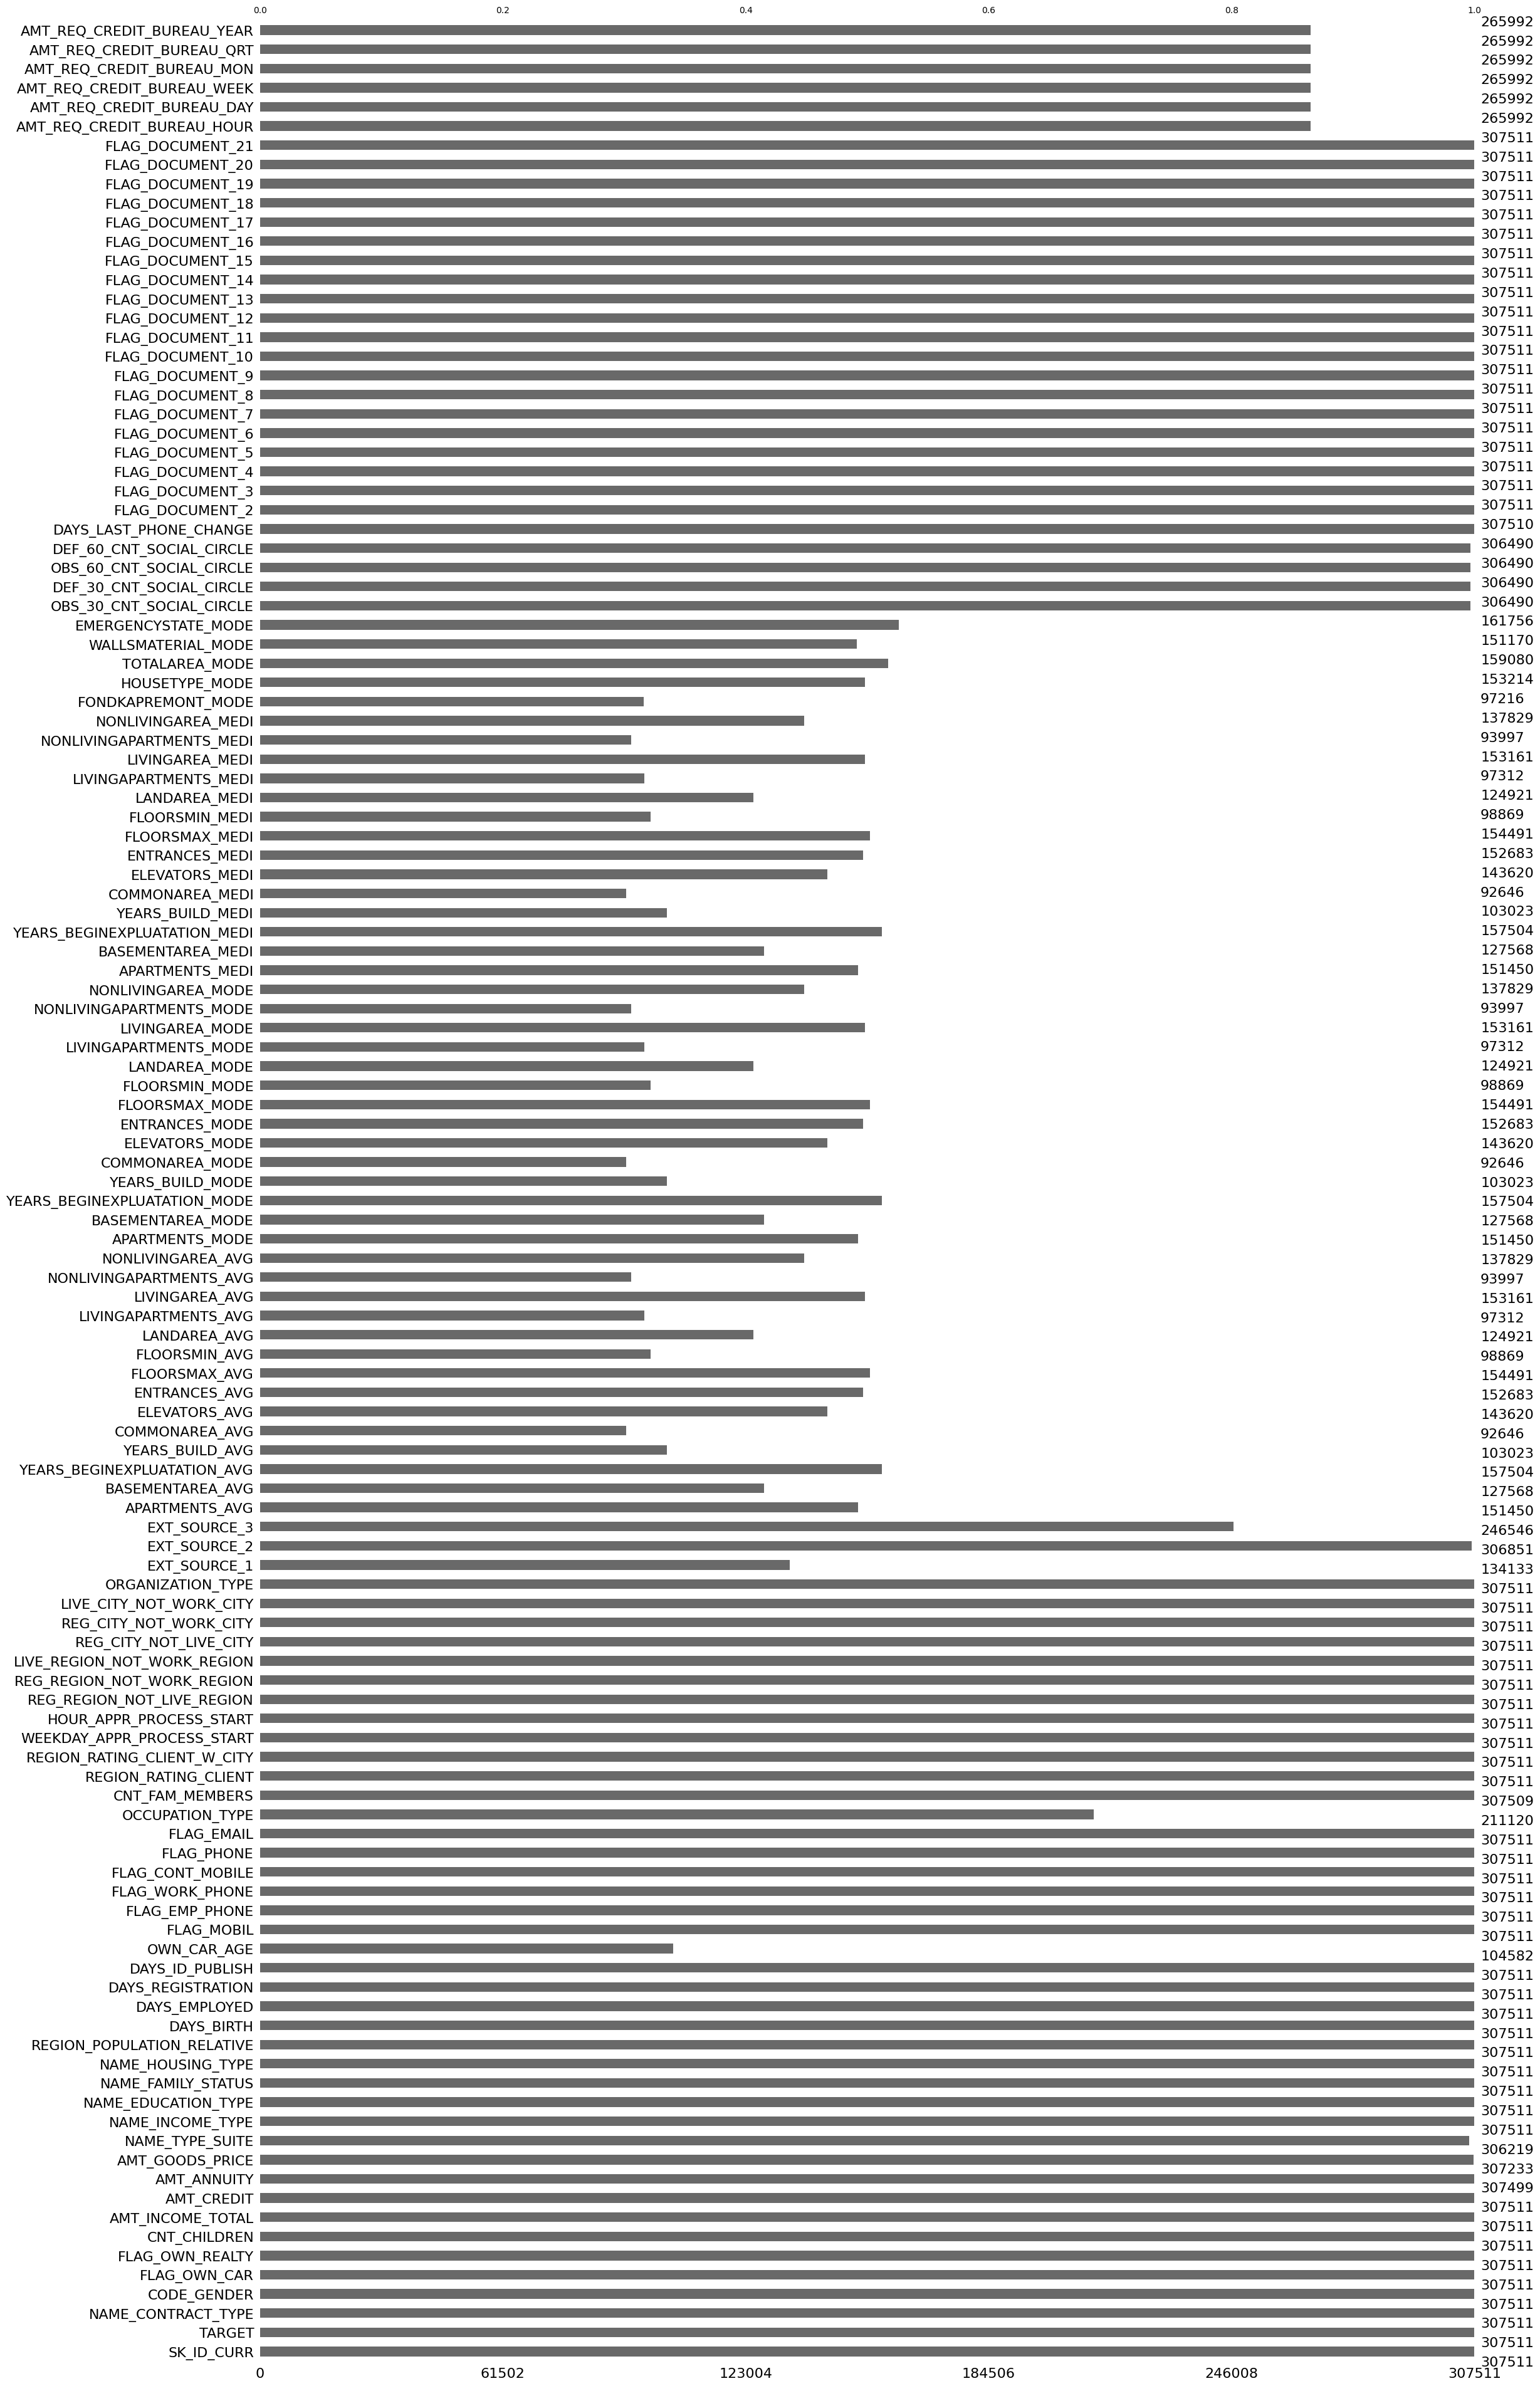

In [25]:
description_dataset(train, "train data")

On observe plusieurs colonnes avec des différents types de variables qui résument des information sur les clients la composition de leurs familles et leurs richesses
Aussi la variable categorielle “CODE GENDER” a une autre categorie(XNA) en plus de categorie: homme femme
Il ya aussi des caractères spéciaux dans d’autres variables.
La variable ‘TARGET’ a 2 modalités: 
  - 0 si le client a remboursé sa dette sans incident
  - 1 si avec incident.


<Axes: title={'center': 'Répartition des types de colonnes'}, ylabel='count'>

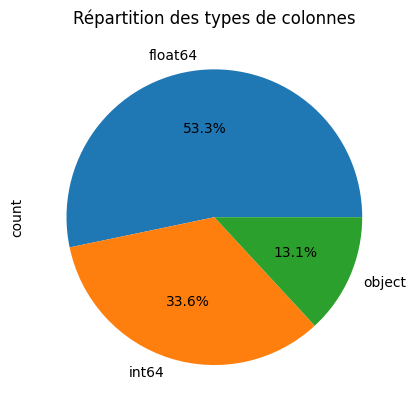

In [26]:
train.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

On voit clairement apparaitre les differents types de variables

In [27]:
train['TARGET'].value_counts()/len(train)*100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

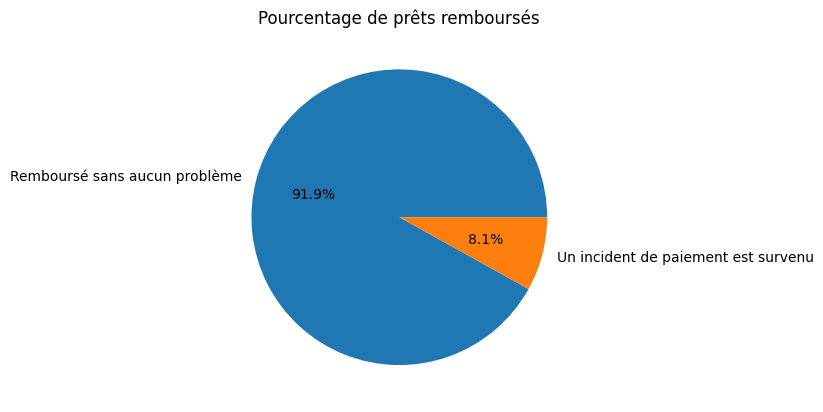

In [28]:
fig = plt.figure()
plt.pie(train['TARGET'].value_counts()/len(train)*100,
        autopct='%1.1f%%',
        labels=["Remboursé sans aucun problème", "Un incident de paiement est survenu"]
       )
plt.title('Pourcentage de prêts remboursés')
plt.show()

PARTIE NETTOYAGE

In [29]:
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité car cas inexistant dans test et 5 occurences 
train = train[train.NAME_INCOME_TYPE != 'Maternity leave']

In [30]:
# on supprime la modalité XNA
train.CODE_GENDER.value_counts()

CODE_GENDER
F      202444
M      105058
XNA         4
Name: count, dtype: int64

In [31]:
train_1=[train.CODE_GENDER != 'XNA']

Application fonction num 4 :cleaning_categories(x))()
caract speciiaux, majiscule etc...

In [32]:
# Colonne type objet (texte)
cols_to_clean = ["NAME_CONTRACT_TYPE",
        "NAME_TYPE_SUITE",
        "OCCUPATION_TYPE",
        "WALLSMATERIAL_MODE",
        "HOUSETYPE_MODE",
        "NAME_HOUSING_TYPE",
        "NAME_FAMILY_STATUS"]

In [33]:
for cols in cols_to_clean: 
    train[cols] = train[cols].apply(lambda x : cleaning_categories(x))

In [34]:
for cols in cols_to_clean: 
    test[cols] = test[cols].apply(lambda x : cleaning_categories(x))

Les Outliers

In [35]:
train.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,307506.0,0.080724,0.272411,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307506.0,0.417036,0.722109,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307506.0,168798.381043,237124.605024,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307506.0,599023.549770,402490.480433,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307494.0,27108.413291,14493.497454,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307228.0,538392.768553,369445.091926,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307506.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307506.0,-16037.014816,4363.989627,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307506.0,63816.126401,141276.660895,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05
DAYS_REGISTRATION,307506.0,-4986.124781,3522.881781,-2.467200e+04,-7479.000000,-4504.000000,-2010.000000,0.000000e+00


-On observe plusieurs variables dont le nom commançant par 'DAYs_' ont des valeurs negatives 
- Aussi l'age 'OWN_CAR_AGE' qui repesente l'age des voitures a des valeurs sup à 60 ans

In [36]:
train.OWN_CAR_AGE.value_counts().sort_index(ascending = False).head(20)

OWN_CAR_AGE
91.0       2
69.0       1
65.0     891
64.0    2443
63.0       2
57.0       1
56.0       1
55.0       4
54.0      12
52.0       1
51.0       3
50.0       1
49.0       6
48.0       1
47.0       1
46.0       5
45.0      11
44.0      21
43.0      19
42.0      42
Name: count, dtype: int64

Ces véhicules dont l'âge dépasse 60 ans peuvent être des véhicules de collection qui sont bien entretenus et peuvent être considere comme des bien de valeurs exceptionnelles

In [37]:
#Pour les variable DAYS, on va convertir les jours en année pour effectuer les analyses

(train['DAYS_BIRTH'] / -365).describe()

count    307506.000000
mean         43.937027
std          11.956136
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

CLS: Pas d'Outlier car le minimum d'âge pour le credit est presque 20 ans et le maximum
est de 69 ans , c'est possible.

In [38]:
print("Nombre maximal de jours où le client occupe son poste actuel précédents la demande :",train['DAYS_EMPLOYED'].max())

Nombre maximal de jours où le client occupe son poste actuel précédents la demande : 365243


Nombre maximal de jours où le client occupe son poste actuel précédents la demande : 365243
Cela correspondrait à 1000 ans, il est clair que c'est un outlier.

Text(0.5, 0, 'Days Employment')

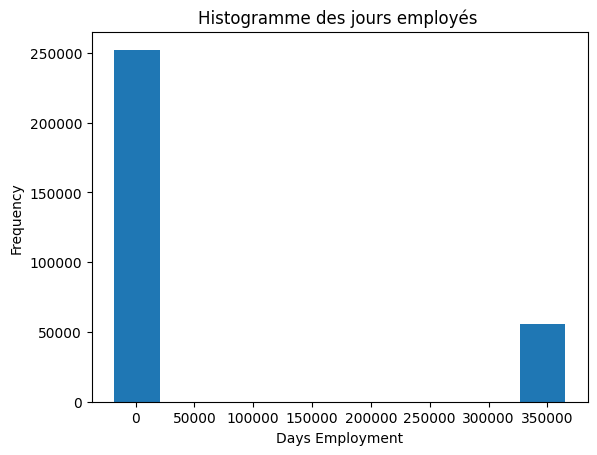

In [39]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours employés ');
plt.xlabel('Days Employment')

In [40]:
#identification des valeurs anormales et non anormales
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('La valeur par défaut des non-anomalies sur le %0.2f%% de prêts' % (100 * non_anom['TARGET'].mean()))
print('La valeur par défaut des anomalies sur le %0.2f%% de prêts' % (100 * anom['TARGET'].mean()))
print('Il y a %d outliers dans la variable days of employment' % len(anom))

La valeur par défaut des non-anomalies sur le 8.66% de prêts
La valeur par défaut des anomalies sur le 5.40% de prêts
Il y a 55374 outliers dans la variable days of employment


La valeur par défaut des non-anomalies sur le 8.66% de prêts
La valeur par défaut des anomalies sur le 5.40% de prêts
Il y a 55374 outliers dans la variable days of employment
C'est extrêmement intéressant !

Il s'avère que les anomalies ont un taux de défaillance plus faible.
Le traitement des anomalies dépend de la situation exacte,
et il n'existe pas de règles fixes. L'une des approches
les plus sûres consiste à définir les anomalies comme
des valeurs manquantes, puis à les compléter (en utilisant
l'imputation) avant l'apprentissage automatique.

Dans ce cas, puisque toutes les anomalies ont exactement
la même valeur, nous voulons les compléter avec la même
valeur au cas où tous ces prêts ont quelque chose en commun.
Les valeurs anormales semblent avoir une certaine importance,
nous voulons donc indiquer au modèle d'apprentissage automatique
si nous avons effectivement rempli ces valeurs.

Comme solution, nous allons remplir les valeurs anormales
avec un nombre nul (np.nan) et ensuite créer une nouvelle
colonne booléenne indiquant si la valeur était anormale ou non.

Text(0.5, 0, 'Days Employment')

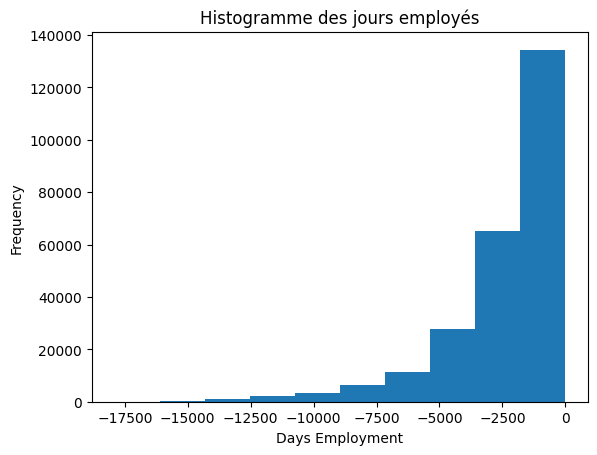

In [41]:
#Création d'une colonne avec le label d'anomalie
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

#On remplace les outliers par des nan
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours employés');
plt.xlabel('Days Employment')

In [42]:
test.describe

<bound method NDFrame.describe of        SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         CASH LOANS           F            N               Y   
1          100005         CASH LOANS           M            N               Y   
2          100013         CASH LOANS           M            Y               Y   
3          100028         CASH LOANS           F            N               Y   
4          100038         CASH LOANS           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         CASH LOANS           F            N               Y   
48740      456222         CASH LOANS           F            N               N   
48741      456223         CASH LOANS           F            Y               Y   
48742      456224         CASH LOANS           M            N               N   
48743      456250         CASH LOANS           F            Y              

In [43]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print("Il y a % d'erreurs sur le nombre de jours en emploi du client dans le dataset de test parmis %d de valeurs" % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

Il y a  9274'erreurs sur le nombre de jours en emploi du client dans le dataset de test parmis 48744 de valeurs


CORRELATION

In [44]:
# Trouvons les corrélations avec la target et trions les
numeric_columns = train.select_dtypes(include=[np.number])  # Select only numeric columns
correlations = numeric_columns.corr()['TARGET'].sort_values()

In [45]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032231
LIVE_CITY_NOT_WORK_CITY        0.032500
OWN_CAR_AGE                    0.037626
DAYS_REGISTRATION              0.041948
FLAG_DOCUMENT_3                0.044379
REG_CITY_NOT_LIVE_CITY         0.044403
FLAG_EMP_PHONE                 0.045975
REG_CITY_NOT_WORK_CITY         0.050981
DAYS_ID_PUBLISH                0.051455
DAYS_LAST_PHONE_CHANGE         0.055227
REGION_RATING_CLIENT           0.058880
REGION_RATING_CLIENT_W_CITY    0.060873
DAYS_EMPLOYED                  0.074972
DAYS_BIRTH                     0.078232
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160453
EXT_SOURCE_1                 -0.155334
FLOORSMAX_AVG                -0.044002
FLOORSMAX_MEDI               -0.043766
FLOORSMAX_MODE               -0.043224
AMT_GOODS_PRICE              -0.039670
REGION_POPULATION_RELATIVE   -0.037225


Regardons certaines des corrélations les plus significatives :

La corrélation DAYS_BIRTH est la plus positive.
La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire que la cible == 0).
C'est un peu déroutant, nous allons donc prendre la valeur absolue de la caractéristique et la corrélation sera alors négative.

In [46]:
# Find the correlation of the positive days since birth and target
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
print("Corrélation entre l'âge du client au moment du prêt et la TARGET :", train['DAYS_BIRTH'].corr(train['TARGET']))

Corrélation entre l'âge du client au moment du prêt et la TARGET : -0.07823164249920539


Plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

Tout d'abord, nous pouvons faire un histogramme de l'âge.
Nous allons mettre l'axe des x en années

Examinons cette variable.
pour rendre le graphique un peu plus compréhensible.

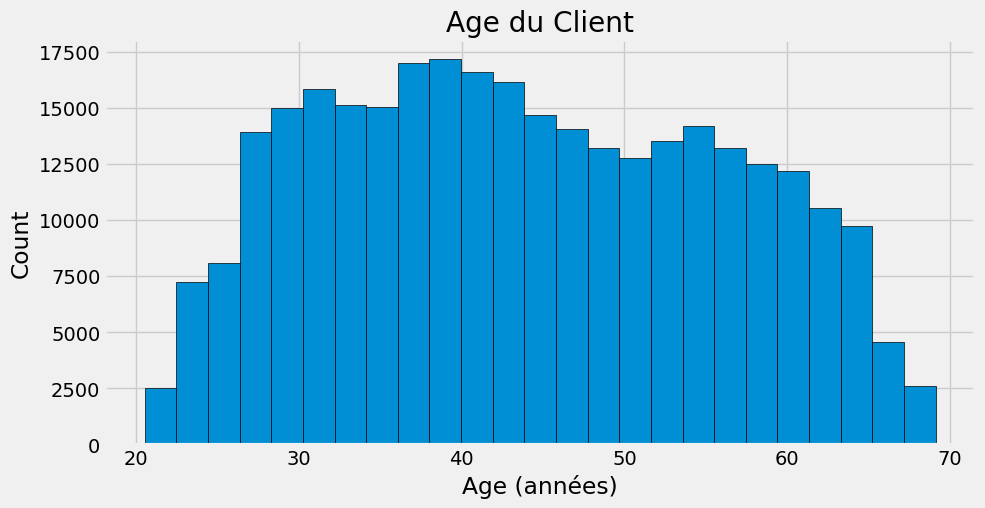

In [47]:
# choix du style du tracé
plt.style.use('fivethirtyeight')

# Tracé de la distribution des ages
plt.figure(figsize=(10,5))
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (années)'); plt.ylabel('Count');

Les variables avec les plus fortes corrélations négatives sont les variables EXT.

Montrons les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

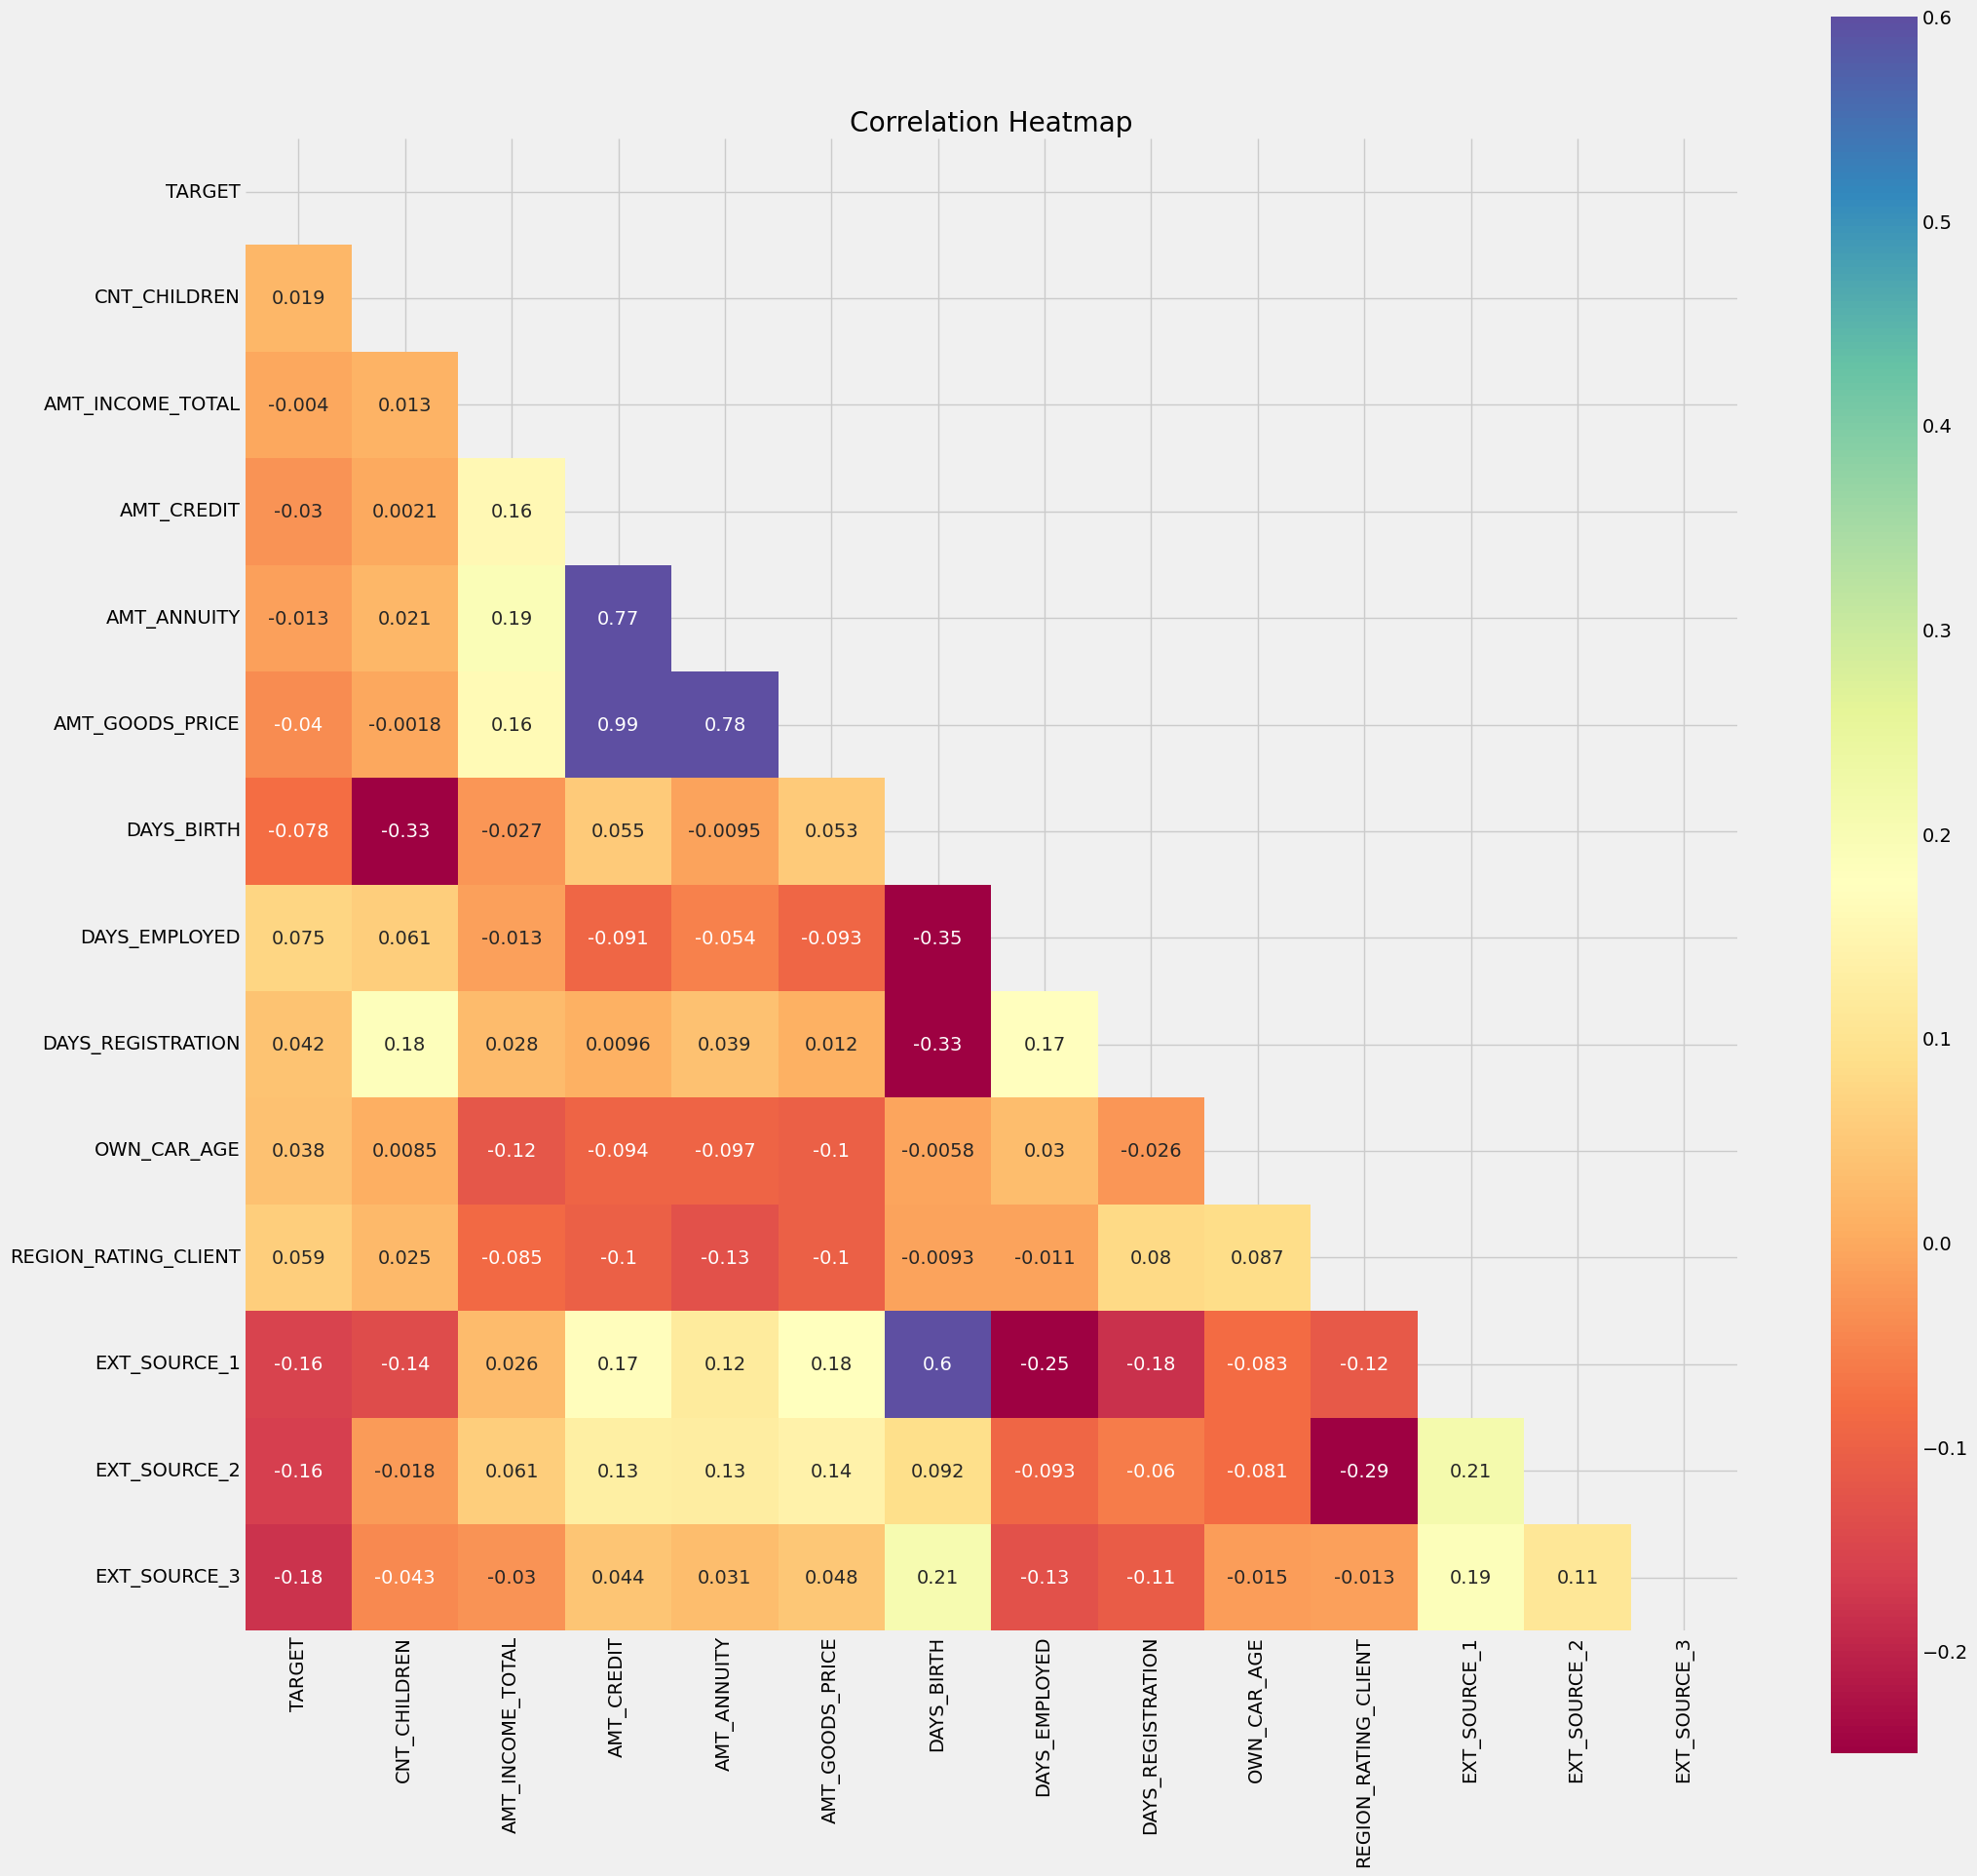

In [48]:
# Select only numeric columns for correlation calculation
ext_data = train[['TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']]

plt.figure(figsize=(22, 22))
mask = np.triu(np.ones_like(ext_data.corr()))

# Heatmap of correlations
sns.heatmap(ext_data.corr(), mask=mask, cmap=plt.cm.Spectral, square=True, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

FEATURE ENGENERING
Création de nouvelles variables simples,
Catégorisation des variables binaires,
Imputation des valeurs manquantes,
Encodage des variables catégorielles,
Normalisation des variables numériques

In [49]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


df_train = train.copy()
df_test = test.copy()

In [50]:
#Récupération des identifiants clients et des labels 
train_ids = df_train["SK_ID_CURR"]
test_ids = df_test["SK_ID_CURR"]


#df_train = df_train.set_index("SK_ID_CURR")
#df_test = df_test.set_index("SK_ID_CURR")


labels = df_train.TARGET

In [51]:
from sklearn.impute import SimpleImputer

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
# Call the clean_data function
features_set, test_features_set = clean_data(df_train, df_test)

Durée d'exécution de cat_encoder: 3.916408061981201s
Training Data Shape:  (307506, 260)
Testing Data Shape:  (48744, 259)
Durée d'exécution de clean_data: 37.07532858848572s


In [54]:
features_set = features_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_features_set = test_features_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [55]:
test_feature_set_sample = test_features_set.sample(frac=0.2)

In [56]:
test_features_sample = test_feature_set_sample.reset_index()

In [57]:
test_features_sample.to_csv("test_preprocess_sample.csv", index=False)

In [58]:
# Sauvegarde de test_set nettoyé
pickle.dump(test_features_sample, open( "test_preprocess_sample.p", "wb")) # type: ignore
    
# Sauvegarde de train_set nettoyé
#with open('fichier_train_preprocess.pickle', 'wb') as fichier:
#    pickle.dump(features_set, fichier, pickle.HIGHEST_PROTOCOL)

MODELISATION

Choix de la métrique utilisée
J'utilise la métrique ROC AUC.

Il s'agit d'une métrique de classification commune connue sous le nom
d'aire sous la courbe de la caractéristique d'exploitation du récepteur
(ROC AUC, parfois aussi appelée AUROC).

La ROC AUC peut sembler intimidante, mais elle est relativement simple
une fois que vous avez compris les deux concepts individuels:

La courbe ROC (Reciever Operating Characteristic) est un graphique
représentant les performances d'un modèle de classification pour tous
les seuils de classification. Cette courbe trace le taux de vrais positifs
en fonction du taux de faux positifs

L'aire sous la courbe (AUC) s'explique par son nom ! Il s'agit simplement
de l'aire sous la courbe ROC. (Il s'agit de l'intégrale de la courbe).
Cette métrique est comprise entre 0 et 1, un meilleur modèle obtenant
un score plus élevé. Un modèle qui se contente de deviner au hasard
aura une AUC ROC de 0,5.

Lorsque nous mesurons un classificateur selon l'AUC ROC,
nous ne générons pas des prédictions 0 ou 1, mais plutôt
une probabilité entre 0 et 1. Cela peut prêter à confusion
car nous aimons généralement penser en termes de précision,
mais lorsque nous sommes confrontés à des problèmes de classes
déséquilibrées, la précision n'est pas la meilleure métrique.
Par exemple, si je voulais construire un modèle capable de
détecter les terroristes avec une précision de 99,9999 %,
je créerais simplement un modèle qui prédit que chaque personne
n'est pas un terroriste.

Il est clair que cela ne serait pas efficace (le rappel serait nul)
et nous utilisons des mesures plus avancées telles que le ROC AUC
ou le score F1 pour refléter plus précisément les performances
d'un classificateur. Un modèle avec un ROC AUC élevé aura
également une précision élevée, mais le ROC AUC est une meilleure

Séparation des dataframes

In [59]:
seed=42

In [60]:
df_X = features_set.drop(columns = 'TARGET')
df_y = features_set['TARGET']
train_set, val_set, train_labels, val_labels = echantillonage(df_X,df_y)

Durée d'exécution de echantillonage: 1.3379387855529785s


In [61]:
train_set['TARGET']=train_labels
val_set['TARGET']=val_labels

In [62]:
train_set = train_set.reset_index()

Création d'échantillons pour les divers tests d'algorithmes

In [63]:
sample_X = features_set.drop(columns = 'TARGET').sample(n= 50000)
sample_y = features_set['TARGET'][sample_X.index]

train_sample_set, val_sample_set, train_sample_labels, val_sample_labels = echantillonage(sample_X,sample_y)

Durée d'exécution de echantillonage: 0.13402462005615234s


In [64]:
train_sample_set['TARGET']=train_sample_labels
val_sample_set['TARGET']=val_sample_labels

In [65]:
train_sample_set

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO,ANNUITY_INCOME_PERC,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUPOFPEOPLE,NAME_TYPE_SUITE_NAN,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSEPARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_CIVILMARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLENOTMARRIED,NAME_FAMILY_STATUS_WIDOW,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_COOPAPARTMENT,NAME_HOUSING_TYPE_HOUSEAPARTMENT,NAME_HOUSING_TYPE_MUNICIPALAPARTMENT,NAME_HOUSING_TYPE_OFFICEAPARTMENT,NAME_HOUSING_TYPE_RENTEDAPARTMENT,NAME_HOUSING_TYPE_WITHPARENTS,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANINGSTAFF,OCCUPATION_TYPE_COOKINGSTAFF,OCCUPATION_TYPE_CORESTAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HIGHSKILLTECHSTAFF,OCCUPATION_TYPE_HRSTAFF,OCCUPATION_TYPE_ITSTAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOWSKILLLABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINESTAFF,OCCUPATION_TYPE_NAN,OCCUPATION_TYPE_PRIVATESERVICESTAFF,OCCUPATION_TYPE_REALTYAGENTS,OCCUPATION_TYPE_SALESSTAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITYSTAFF,OCCUPATION_TYPE_WAITERSBARMENSTAFF,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS

In [66]:
train_sample_set = train_sample_set.reset_index()

In [67]:
print('train shape :',train_set.shape)
print('validation shape :',val_set.shape)


print('train sample shape :',train_sample_set.shape)
print('validation sample shape :',val_sample_set.shape)

train shape : (246004, 261)
validation shape : (61502, 260)
train sample shape : (40000, 261)
validation sample shape : (10000, 260)


In [68]:
#sauvegarde des train set et val set
pickle.dump( train_set, open( "train_set.p", "wb" ) )
pickle.dump( val_set, open( "val_set.p", "wb" ) )

In [69]:
#chargement des train set et val set 
train_set = pickle.load( open( "train_set.p", "rb" ) )
val_set = pickle.load( open( "val_set.p", "rb" ) )

In [70]:
# Dictionnaire de classifieurs 
classifieurs = { 'Dummy Classifier': DummyClassifier(),
                
                'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000),
                'LGBM': lgb.LGBMClassifier()
            }

Dummy Classifier
Logistic Regression
LGBM
[LightGBM] [Info] Number of positive: 2578, number of negative: 29422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12943
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080562 -> initscore=-2.434729
[LightGBM] [Info] Start training from score -2.434729
[LightGBM] [Info] Number of positive: 2604, number of negative: 29396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12960
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 229
[LightGBM] [Info] [binary:BoostFromSco

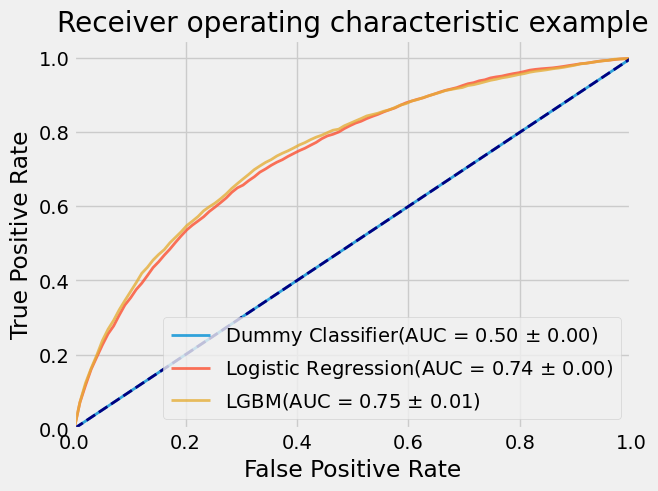

Durée d'exécution de plot_roc_curve: 57.95344400405884s


In [71]:
plot_roc_curve(classifieurs,train_sample_set.drop(columns = 'TARGET'),train_sample_labels, n_splits = 5)

Nous allons choisir le LGBM pour notre probleme. Afin de discriminer correctement les Faux négatifs nous créons une fonction cout métier, qui pondère chaque faux négatif à -10

Rééquilibrage et choix du modèle
Class Weight

In [ ]:
#Class Weight
best_par_0, feat_imp_0, model_0 = optimisation_model(train_sample_set, lgb.LGBMClassifier(),metric = cout_metier, n_ite_baye=5)

In [74]:
best_par_0

{'colsample_by_tree': 0.9,
 'learning_rate': 0.05322996679803793,
 'max_depth': 12.0,
 'n_estimators': 600.0,
 'num_leaves': 16.0,
 'reg_alpha': 0.2,
 'reg_lambda': 0.1,
 'seuil': 0.8250000000000001,
 'subsample': 0.8}

Durée d'exécution de gain_seuil: 34.94306492805481s


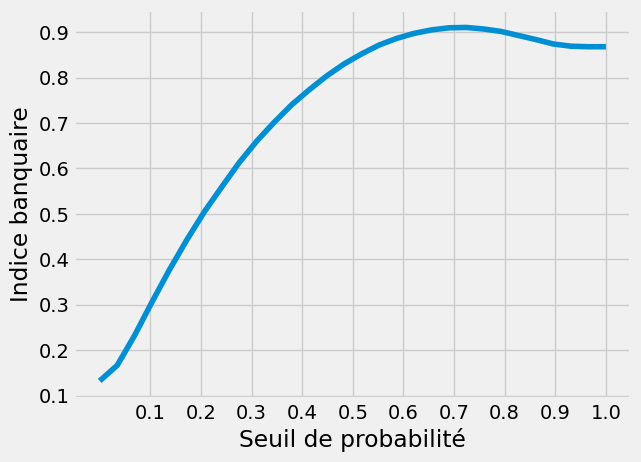

In [75]:
gain_seuil(model_0, train_sample_labels, train_sample_set.drop(columns = ['TARGET','SK_ID_CURR']))

In [76]:
y_proba = model_0.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba = y_proba > best_par_0['seuil']
y_pred_proba = np.array(y_pred_proba > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score= roc_auc_score(val_sample_labels,y_pred_proba)

print ("ROC auc score : ",score)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba))

ROC auc score :  0.5358740717669961
métrique métier :  0.8645446424373502


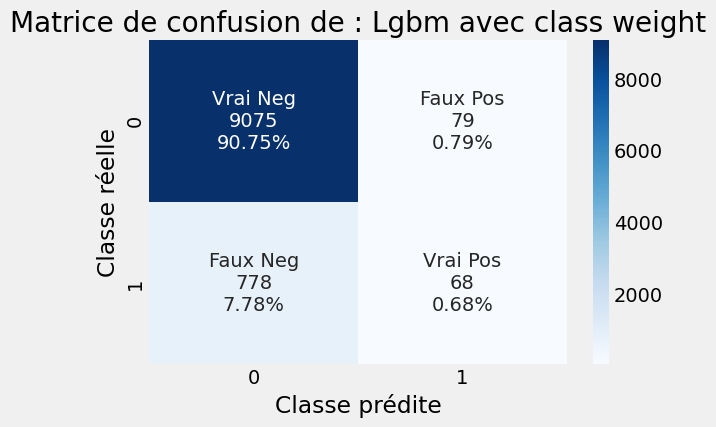

Durée d'exécution de afficher_matrice_confusion: 0.5101966857910156s


In [77]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba, "Lgbm avec class weight")  # poids

In [ ]:
#Smote ou oversampling
best_par_smote, feat_imp_smote, model_smote = optimisation_model(train_sample_set, lgb.LGBMClassifier(),metric = cout_metier,smote = True, n_ite_baye=5)

In [79]:
best_par_smote

{'colsample_by_tree': 0.7000000000000001,
 'learning_rate': 0.007626824368712241,
 'max_depth': 12.0,
 'n_estimators': 1200.0,
 'num_leaves': 56.0,
 'reg_alpha': 0.5,
 'reg_lambda': 0.30000000000000004,
 'seuil': 0.47500000000000003,
 'subsample': 0.6000000000000001}

Durée d'exécution de gain_seuil: 166.46529912948608s


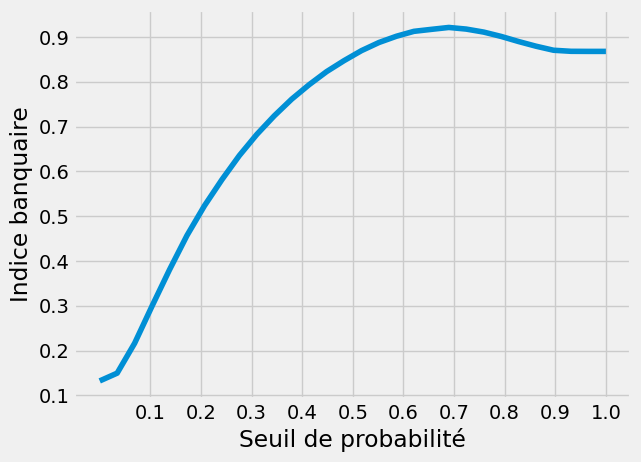

In [80]:
gain_seuil(model_smote, train_sample_labels, train_sample_set.drop(columns = ["SK_ID_CURR",'TARGET']))

In [81]:
y_proba_smote = model_smote.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_smote = y_proba_smote > best_par_smote['seuil']
y_pred_proba_smote = np.array(y_pred_proba_smote > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_smote= roc_auc_score(val_sample_labels,y_pred_proba_smote)

print ("ROC auc score : ",score_smote)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_smote))

ROC auc score :  0.6840354770047172
métrique métier :  0.7613898161643707


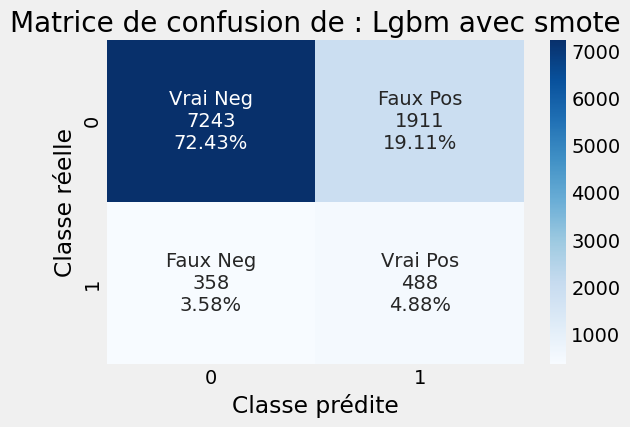

Durée d'exécution de afficher_matrice_confusion: 0.359011173248291s


In [82]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_smote, "Lgbm avec smote")

UnderSampling

In [ ]:
best_parameters_us, feature_importance_us, model_us = optimisation_model(train_sample_set, lgb.LGBMClassifier(),
                                                                             metric=cout_metier, under=True,
                                                                             n_ite_baye=5
                                                                             )

In [84]:
best_parameters_us

{'colsample_by_tree': 0.7000000000000001,
 'learning_rate': 0.006962715800858051,
 'max_depth': 4.0,
 'n_estimators': 1400.0,
 'num_leaves': 8.0,
 'reg_alpha': 1.0,
 'reg_lambda': 0.4,
 'seuil': 0.625,
 'subsample': 0.8}

Durée d'exécution de gain_seuil: 71.08958292007446s


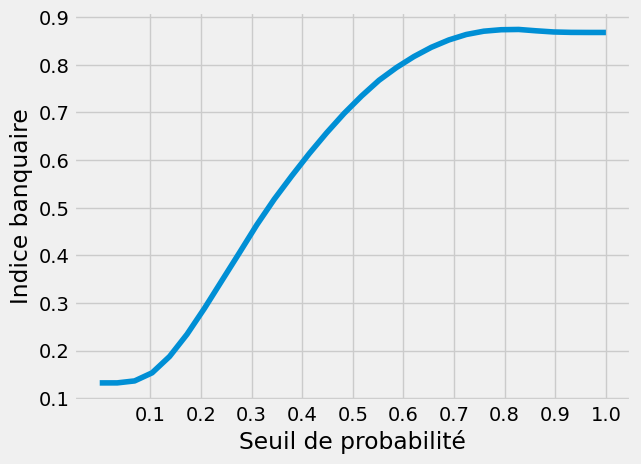

In [85]:
gain_seuil(model_us, train_sample_labels, train_sample_set.drop(columns = ["SK_ID_CURR",'TARGET']))

In [86]:
y_proba_us = model_us.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_us = y_proba_us > best_parameters_us['seuil']
y_pred_proba_us = np.array(y_pred_proba_us > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_us= roc_auc_score(val_sample_labels,y_pred_proba_us)

print ("ROC auc score : ",score_us)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_us))

ROC auc score :  0.6677677368237013
métrique métier :  0.8101462222013259


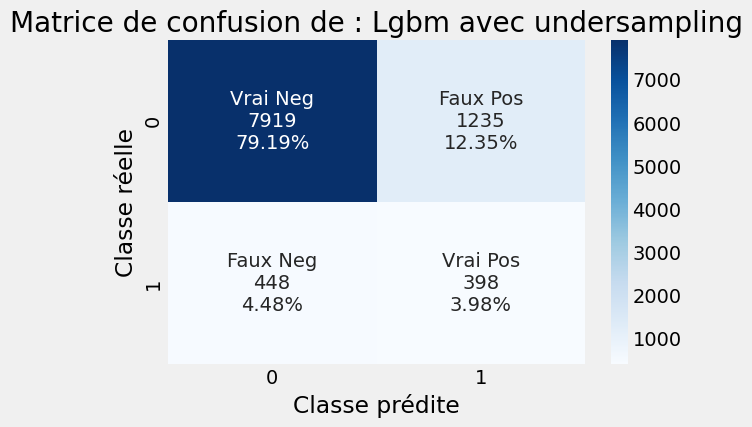

Durée d'exécution de afficher_matrice_confusion: 0.5319969654083252s


In [87]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_us, "Lgbm avec undersampling")

In [88]:
#Dictionnaire de modèles
dict_model={'class_weight':model_0,
            'Over_sampling':model_smote,
            'Under_sampling':model_us
           }

In [89]:
name,score, target_0, target_1=score_validation_set(dict_model)

val_list={'Sampling':'True_val',
          'Pred_0':(val_sample_set['TARGET'].value_counts()/len(val_sample_set)*100)[0].item(),
          'Pred_1':(val_sample_set['TARGET'].value_counts()/len(val_sample_set)*100)[1].item()}

df_score=pd.DataFrame()
df_score['Sampling']=name
df_score['metrique metier']=score
df_score['Pred_0']=target_0
df_score['Pred_1']=target_1
df_score

,Sampling,metrique metier,Pred_0,Pred_1
0,class_weight,0.777093,79.574648,20.425352
1,Over_sampling,0.790345,81.000618,18.999382
2,Under_sampling,0.704566,70.914767,29.085233


In [90]:
df_score['metrique metier']=df_score['metrique metier']*100
df_score.loc[3] = val_list

In [91]:
df_score

,Sampling,metrique metier,Pred_0,Pred_1
0,class_weight,77.709310,79.574648,20.425352
1,Over_sampling,79.034534,81.000618,18.999382
2,Under_sampling,70.456620,70.914767,29.085233
3,True_val,NaN,91.540000,8.460000


Le modele retenu est celui avec over sampling / smote car il se rapproche le plus des valeurs initiales.

In [92]:
# Sauvegarde du meilleur modèle dans best_model
fichier_best_model = 'best_model.pickle'
with open(fichier_best_model, 'wb') as fichier:
    pickle.dump(model_smote, fichier, pickle.HIGHEST_PROTOCOL)

Predictions
Ajout des nouvelles variables sur le test

In [93]:
df_test = test.copy()
df_test['PROPORTION_LIFE_EMPLOYED'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
df_test['INCOME_TO_CREDIT_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']
df_test['INCOME_TO_ANNUITY_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_ANNUITY']
df_test['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = df_test['INCOME_TO_ANNUITY_RATIO'] * -df_test['DAYS_BIRTH']
df_test['CREDIT_TO_ANNUITY_RATIO'] = df_test['AMT_CREDIT'] / df_train['AMT_ANNUITY']
df_test['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = df_test['CREDIT_TO_ANNUITY_RATIO'] * -df_test['DAYS_BIRTH']
df_test['INCOME_TO_FAMILYSIZE_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']
df_test['ANNUITY_INCOME_PERC'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']

In [94]:
y_test_pred_proba=model_smote.predict_proba(test_features_set)[:, 1]

seuil=best_par_smote['seuil'] 
y_seuil_test = y_test_pred_proba > seuil
y_seuil_test = np.array(y_seuil_test> 0)*1


df_test_pred=df_test.copy()
df_test_pred['Proba']=y_test_pred_proba
df_test_pred['PREDICTION']=y_seuil_test
df_test_pred.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO,ANNUITY_INCOME_PERC,Proba,PREDICTION
0,100001,CASH LOANS,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,UNACCOMPANIED,Working,Higher education,MARRIED,HOUSE APARTMENT,0.018850,-19241,-2329.0,-5170.0,-812,NaN,1,1,0,1,0,1,NAN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,BLOCK OF FLATS,0.0392,"STONE, BRICK",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.121044,0.237342,6.565988,126336.178595,23.027874,4.430793e+05,67500.0,0.152300,0.250956,0
1,100005,CASH LOANS,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,UNACCOMPANIED,Working,Secondary / secondary special,MARRIED,HOUSE APARTMENT,0.035792,-18064,-4469.0,-9118.0,-1623,NaN,1,1,0,1,0,0,LOWSKILL LABORERS,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NAN,NaN,NAN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,False,0.247398,0.444409,5.699482,102955.440415,6.240262,1.127241e+05,49500.0,0.175455,0.409420,0
2,100013,CASH LOANS,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NAN,Working,Higher education,MARRIED,HOUSE APARTMENT,0.019101,-20038,-4458.0,-2175.0,-3503,5.0,1,1,0,1,0,0,DRIVERS,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Tran

In [95]:
df_test_pred[df_test_pred.PREDICTION == 1]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO,ANNUITY_INCOME_PERC,Proba,PREDICTION
25,100172,CASH LOANS,F,N,Y,0,76500.0,225000.0,12334.5,225000.0,UNACCOMPANIED,Working,Secondary / secondary special,CIVIL MARRIAGE,HOUSE APARTMENT,0.010966,-15394,-967.0,-5389.0,-5433,NaN,1,1,0,1,0,0,LABORERS,2.0,2,2,TUESDAY,10,0,0,0,0,1,1,Business Entity Type 3,NaN,0.348886,0.535276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NAN,NaN,NAN,NaN,4.0,2.0,4.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,False,0.062817,0.340000,6.202116,95475.373951,20.316944,312759.041040,38250.0,0.161235,0.599670,1
37,100278,CASH LOANS,F,N,Y,1,121500.0,450000.0,35685.0,450000.0,UNACCOMPANIED,Working,Secondary / secondary special,MARRIED,HOUSE APARTMENT,0.005002,-10834,-1787.0,-4039.0,-365,NaN,1,1,1,1,0,0,SALES STAFF,3.0,3,3,TUESDAY,15,0,0,0,0,0,0,Business Entity Type 3,0.430628,0.472079,0.300108,0.0062,NaN,0.9657,0.5308,NaN,NaN,NaN,0.0000,NaN,NaN,0.0050,0.0022,NaN,0.0000,0.0063,NaN,0.9657,0.5492,NaN,NaN,NaN,0.0000,NaN,NaN,0.0055,0.0023,NaN,0.0000,0.0062,NaN,0.9657,0.5371,NaN,NaN,NaN,0.0000,NaN,NaN,0.0051,0.0023,NaN,0.0000,reg oper spec account,BLOCK OF FLATS,0.0028,WOODEN,No,5.0,1.0,5.0,1.0,-358.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,False,0.164944,0.270000,3.404792,36887.515763,29.700030,321770.121770,40500.0,0.293704,0.504022,1
39,100306,CASH LOANS,M,N,N,0,112500.0,360000.0,28570.5,360000.0,UNACCOMPANIED,Working,Secondary / secondary special,SINGLE NOT MARRIED,WITH PARENTS,0.0100

In [96]:
best_par_smote['seuil']

0.47500000000000003

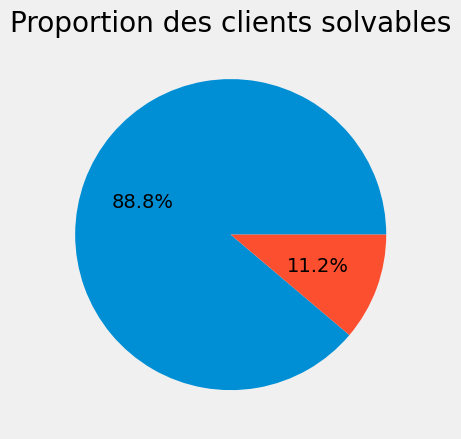

In [97]:
plt.title("Proportion des clients solvables")
plt.pie(df_test_pred["PREDICTION"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [98]:
# Sauvegarde des prédictions
fichier_prediction_test = 'test_prediction.pickle'
with open(fichier_prediction_test, 'wb') as fichier:
    pickle.dump(df_test_pred, fichier, pickle.HIGHEST_PROTOCOL)

Interprétation des résultats avec SHAP
Interprétation globale

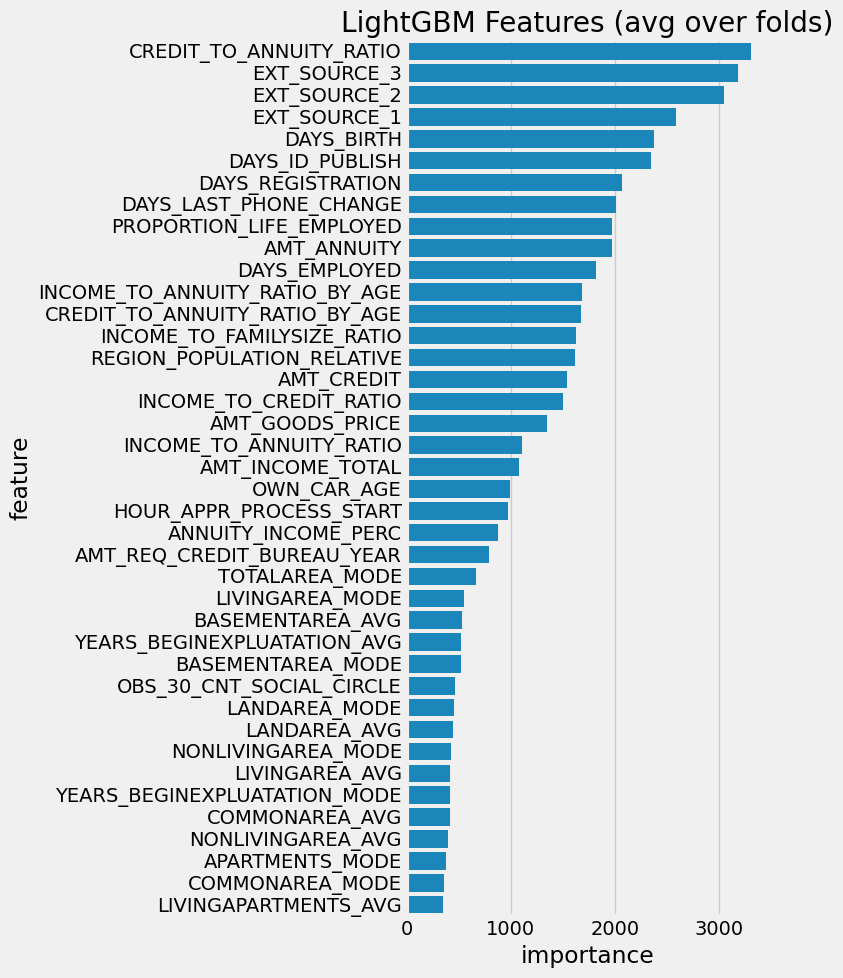

In [99]:
display_importances(feat_imp_smote, train_sample_set)

In [101]:
val_sample_set_t =val_sample_set.drop(columns =["TARGET"])
val_sample_set_0 = val_sample_set_t.reset_index()

c:\Users\Dell\anaconda3\envs\tf_n\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


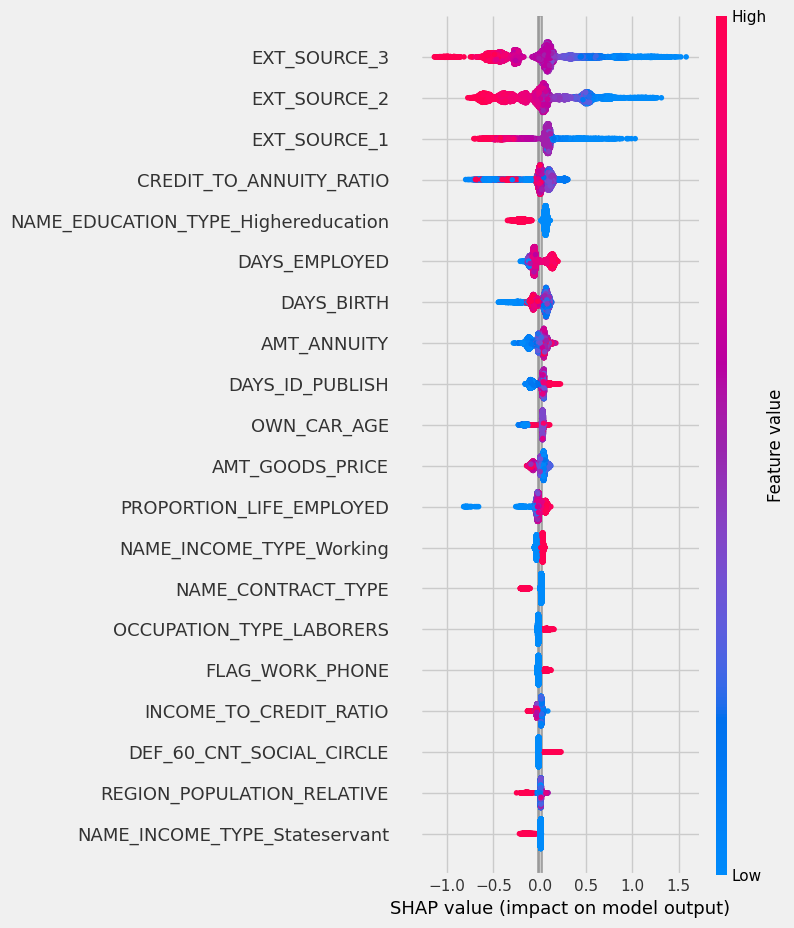

In [102]:
#val_sample_labels = val_sample_labels.astype('float32')
train_sample_labels = train_sample_labels.astype('float32')


explainer_shap = shap.TreeExplainer(model_us)
shap_values = explainer_shap.shap_values(val_sample_set_t)
# Summary plot
shap.summary_plot(shap_values,val_sample_set.drop(columns =["TARGET"]))

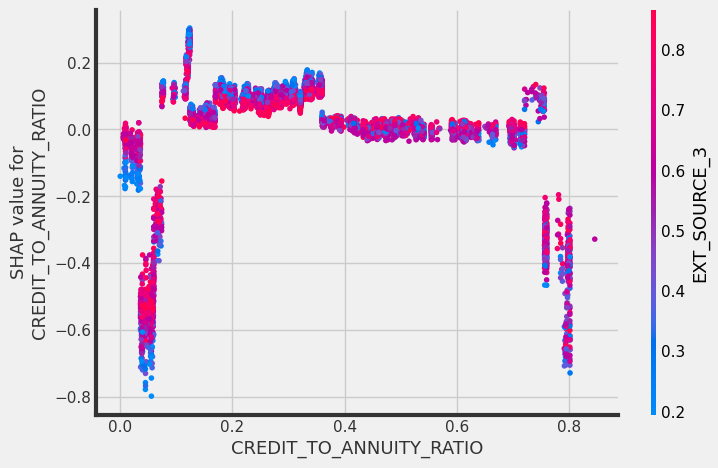

In [106]:

shap.dependence_plot("CREDIT_TO_ANNUITY_RATIO", shap_values, val_sample_set.drop(columns =["TARGET"]))

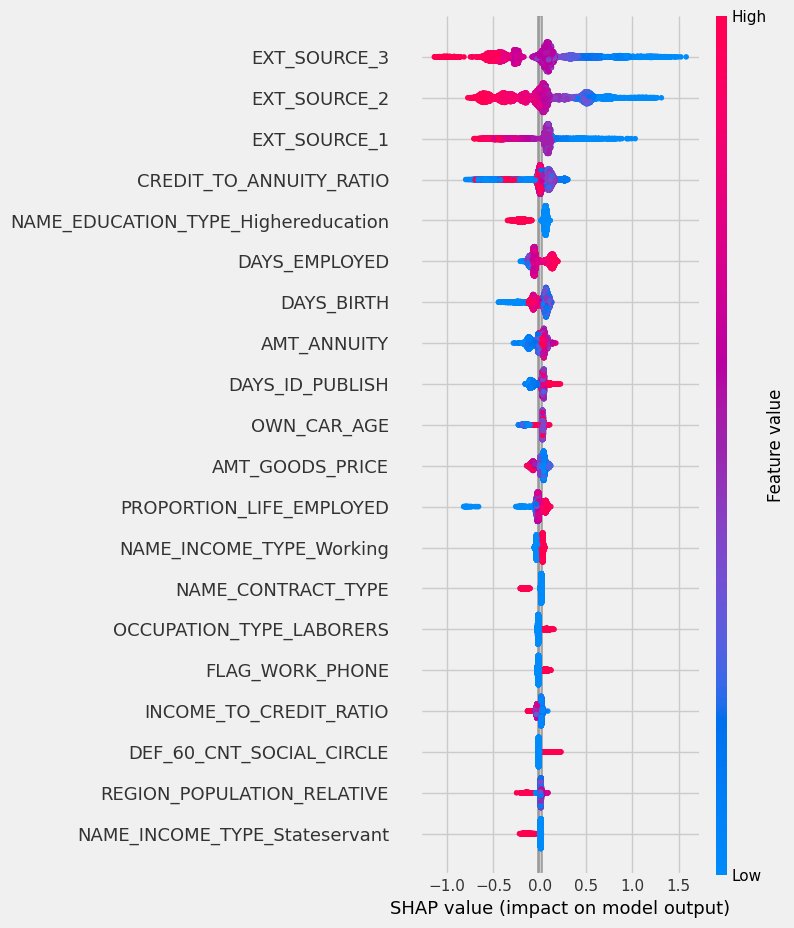

In [107]:
shap.summary_plot(shap_values, val_sample_set.drop(columns =["TARGET"]), show=False)

In [108]:
pickle.dump(shap_values, open( "shap_values.p", "wb" ) )

c:\Users\Dell\anaconda3\envs\tf_n\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


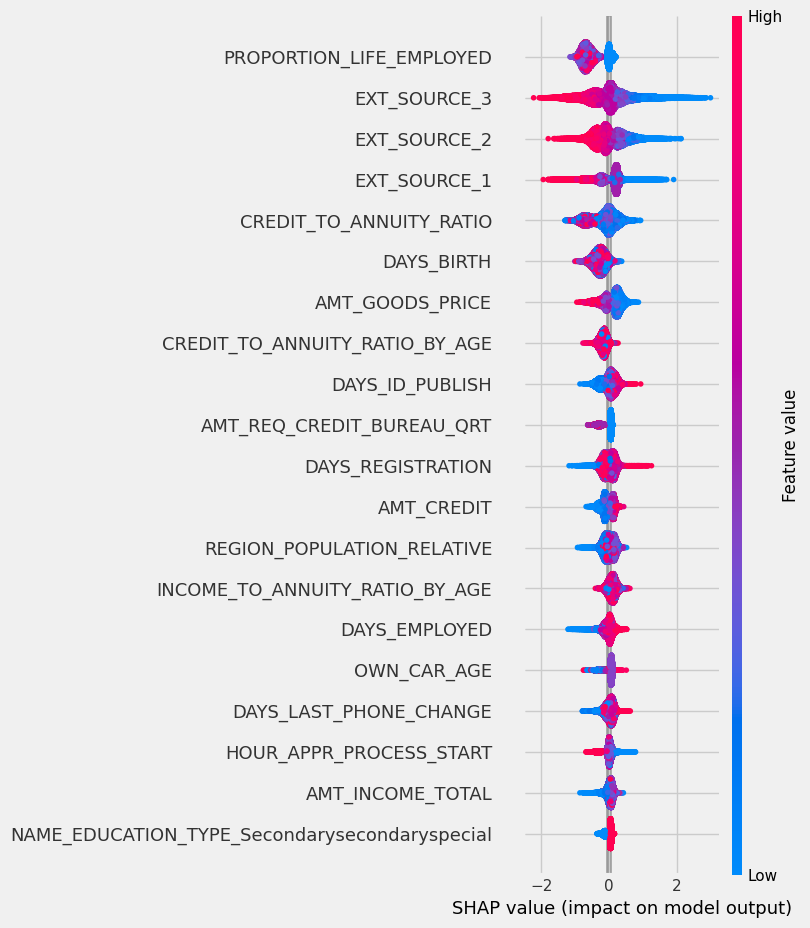

In [ ]:
shap_values_test = explainer_shap.shap_values(test_features_set)

# Use shap_values_test instead of shap_values to ensure consistency
shap.summary_plot(shap_values_test, test_features_set)

ANALYSE DU DATA DRIFT AVEC LA LIBRAIRY EVIDENTLY


L'objectif est de tester l’utilisation de la librairie evidently pour détecter dans le futur du Data Drift en production.

Le data drift (ou dérive de données) se produit lorsqu'il y a des changements de distribution entre les données utilisées en entrée d’un modèle de ML et les données qui ont été utilisées pour entraîner ce modèle (changements liés à diverses raisons : évolution des tendances, changements dans les comportements, erreurs dans les données d'entrée…). Si les données sur lesquelles le modèle a été entraîné ne reflète plus les données en production, le data drift peut impacter la performance du modèle. Il est donc important de surveiller régulièrement les données d'entrée et de ré-entraîner le modèle si nécessaire afin de maintenir sa précision et sa fiabilité au fil du temps.

Nous prendrons comme hypothèse que le dataset “application_train” représente les données pour la modélisation et le dataset “application_test” représente les données de nouveaux clients une fois le modèle en production.

L’analyse à l’aide d’evidently nous permettra de détecter éventuellement du Data Drift sur les principales features, entre les data d’entraînement et les data de production, au travers du tableau HTML de rapport issu du traitement.

In [ ]:
pip install evidently
import pandas as pd
from evidently import Report
from evidently import Dataset, DataDefinition

!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1

from evidently.presets import DataDriftPreset
import pandas as pd
from evidently import Report
from evidently import Dataset, DataDefinition
from evidently.descriptors import Sentiment, TextLength, Contains
from evidently.presets import TextEvals


# Charger les datasets d'entraînement et de test
train_df = pd.read_csv("/content/sample_data/application_train.csv")
test_df = pd.read_csv("/content/sample_data/application_test.csv")

# Créer le rapport
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=train_df, current_data=test_df)